In [1]:
import tensorflow as tf

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

import keras

In [2]:
image_dim= 28*28
noise_dim= 10

In [3]:
(x_train, y_train), (x_test, y_test)= mnist.load_data()

x_train= x_train/255

x_train= x_train.reshape(-1, image_dim)



In [4]:
# def take_only_one_class(class_id):
#   global x_train
#   new_x_train= list()
#   for (index,element) in enumerate(y_train):
#     if element == class_id:
#       new_x_train.append(x_train[index])
#   x_train= new_x_train
#   x_train= np.array(x_train)

# take_only_one_class(2)

In [5]:
image_index= 0
def draw_image(image):
  global image_index
  i= image.reshape(28,28)
  plt.figure()
  plt.imshow(i)
  plt.colorbar()
  image_index+=1
  plt.savefig("Image_"+str('%05d' % image_index)+".png")


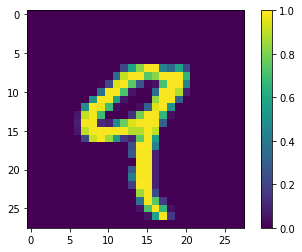

In [6]:
draw_image(x_train[4])



---


# **Lets make the models**


---



In [7]:
def generator(ip_size, op_size):
  model= keras.models.Sequential()
  model.add(keras.layers.Dense(units=7*7, activation='tanh', input_shape=(ip_size,)))
  model.add(keras.layers.Dense(units=14*14, activation='tanh'))
  model.add(keras.layers.Dense(units=21*21, activation='tanh'))
  model.add(keras.layers.Dense(units=op_size, activation='sigmoid'))
  return model

In [8]:
def discremenetor(ip_size):
  model= keras.models.Sequential()
  model.add(keras.layers.Dense(units=1024, activation='relu', input_shape=(ip_size,)))
  model.add(keras.layers.Dense(units=256, activation='relu'))
  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dense(units=1, activation='sigmoid'))
  # opt= keras.optimizers.SGD(learning_rate=0.005)
  # model.compile(optimizer=opt, loss='mse')
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [9]:
def generator_2(latent_dim= 100):
  model = keras.models.Sequential()
  n_nodes = 128 * 7 * 7
  model.add(keras.layers.Dense(n_nodes, input_dim= latent_dim))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Reshape((7, 7, 128)))
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model


In [10]:
def discremenetor_2(in_shape=(28,28,1)):
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [11]:
def generate_noise(size, count=1):
  res= list()
  for _ in range(count):
    sampl = np.random.uniform(low=0.0, high=1, size=(size,))
    res.append(sampl)
  return np.array(res)


def get_n_images(n):
  res= list()
  for _ in range(n):
    index= random.randint(0, len(x_train)-1)
    res.append(x_train[index])
  return res


def unison_shuffled_copies(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]


In [12]:
def train_discriminator(g_model, d_model, size= 60000, epochs=1, batch_size= 1000):

  d_model.trainable= True

  half_size= int(size/2)

  real_image= get_n_images(half_size)
  real_image= np.array(real_image)

  noise= generate_noise(noise_dim, count=half_size)
  fake_image= g_model.predict(noise)

  xs= np.concatenate([real_image,fake_image])
  ys= np.concatenate([ np.ones(half_size), np.zeros(half_size) ])

  xs, ys= unison_shuffled_copies(xs, ys)


  d_model.fit(xs, ys, epochs=epochs , batch_size=batch_size )



In [13]:
def train_generator(g_model, d_model, size= 60000, epochs=3,  batch_size= 1000):

  model= keras.models.Sequential()
  d_model.trainable= False
  model.add(g_model)
  model.add(d_model)
  # opt= keras.optimizers.SGD(learning_rate=0.005)
  # model.compile(optimizer=opt, loss='mse')
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  xs= generate_noise(noise_dim, count=size)
  ys= np.ones(size)

  model.fit(xs, ys, epochs=epochs , batch_size=batch_size)


In [14]:
g_model= generator(noise_dim, image_dim)
d_model= discremenetor(image_dim)




In [15]:
# g_model= generator_2()
# d_model= discremenetor_2()
# x_train= x_train.reshape(-1,28,28)

# def draw_image(image):
#   # i= image.reshape(28,28)
#   plt.figure()
#   plt.imshow(i)
#   plt.colorbar()




	Training for  1 th time


60/60 [==============================] - 9s 57ms/step - loss: 0.1651 - accuracy: 0.9492
--------------
Epoch 1/3
60/60 [==============================] - 6s 82ms/step - loss: 3.4756 - accuracy: 0.3857
Epoch 2/3
60/60 [==============================] - 5s 77ms/step - loss: 0.0074 - accuracy: 0.9993
Epoch 3/3
60/60 [==============================] - 5s 79ms/step - loss: 0.0024 - accuracy: 1.0000


	Training for  2 th time


60/60 [==============================] - 3s 56ms/step - loss: 0.0809 - accuracy: 0.9906
--------------
Epoch 1/3
60/60 [==============================] - 6s 79ms/step - loss: 2.7893 - accuracy: 0.5376
Epoch 2/3
60/60 [==============================] - 5s 79ms/step - loss: 0.0101 - accuracy: 0.9970
Epoch 3/3
60/60 [==============================] - 5s 79ms/step - loss: 0.0034 - accuracy: 0.9990


	Training for  3 th time


60/60 [==============================] - 3s 56ms/step - loss: 0.0959 - accuracy: 0.9860
--------------
Epoch 1/3
60/60 

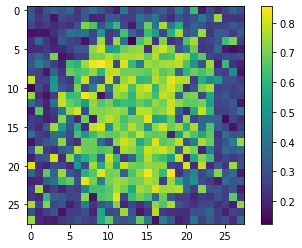

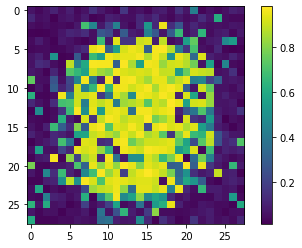

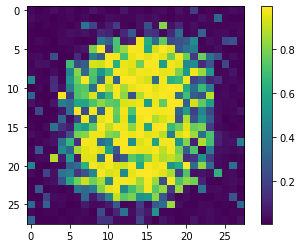

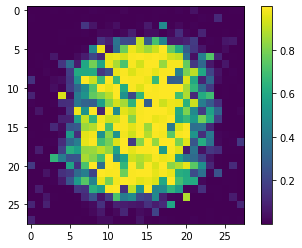

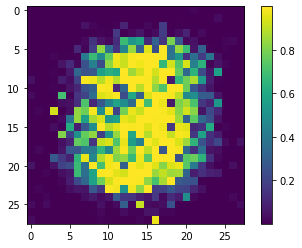

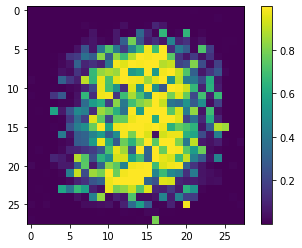

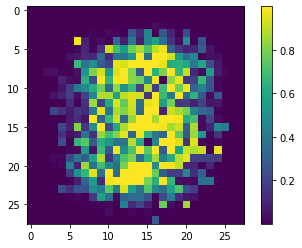

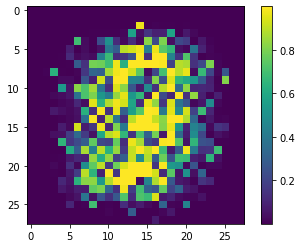

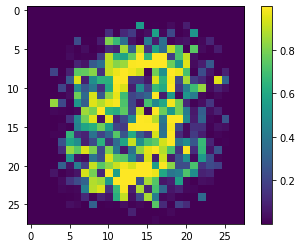

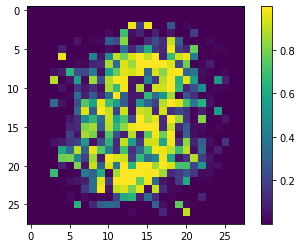

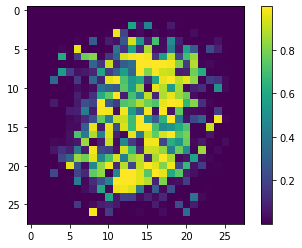

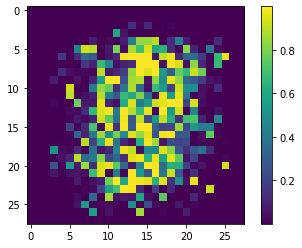

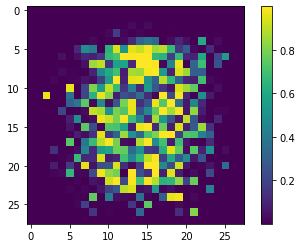

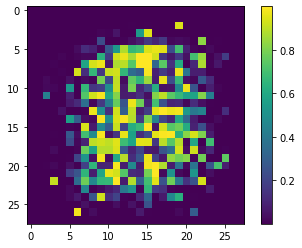

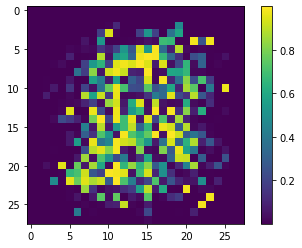

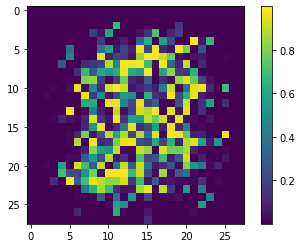

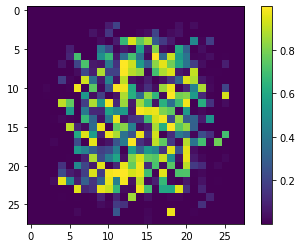

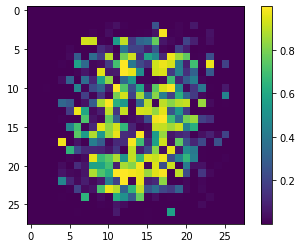

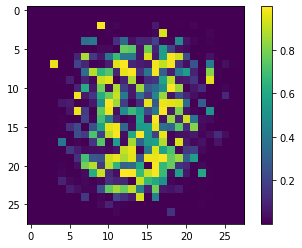

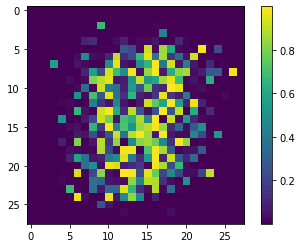

In [16]:
for i in range(20):
  print("\n\n\tTraining for ", (i+1), "th time\n\n")
  
  train_discriminator(g_model, d_model)

  print("--------------")

  train_generator(g_model, d_model)

  noise= generate_noise(noise_dim)
  image= g_model.predict(noise)
  draw_image(image[0])



	Training for  1 th time


60/60 [==============================] - 3s 54ms/step - loss: 0.0788 - accuracy: 0.9871
--------------
Epoch 1/3
60/60 [==============================] - 5s 77ms/step - loss: 2.3212 - accuracy: 0.4637
Epoch 2/3
60/60 [==============================] - 5s 77ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 75ms/step - loss: 0.0025 - accuracy: 1.0000


	Training for  2 th time


60/60 [==============================] - 3s 54ms/step - loss: 0.0761 - accuracy: 0.9880
--------------
Epoch 1/3
60/60 [==============================] - 5s 76ms/step - loss: 2.3671 - accuracy: 0.4637
Epoch 2/3
60/60 [==============================] - 5s 76ms/step - loss: 0.0135 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 76ms/step - loss: 0.0037 - accuracy: 1.0000


	Training for  3 th time


60/60 [==============================] - 3s 52ms/step - loss: 0.0760 - accuracy: 0.9874
--------------
Epoch 1/3
60/60 

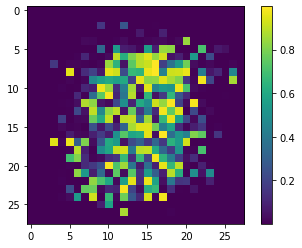

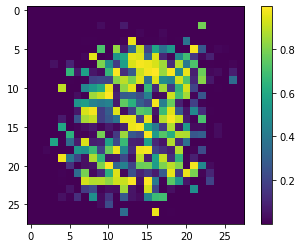

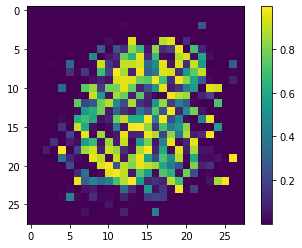

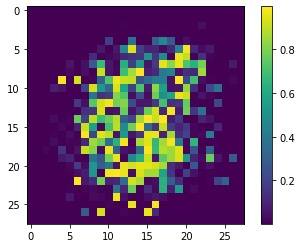

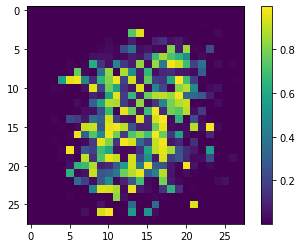

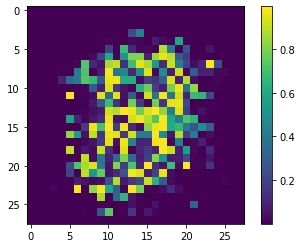

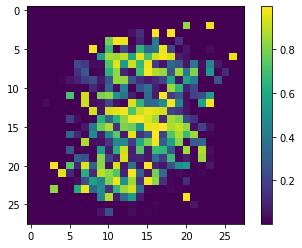

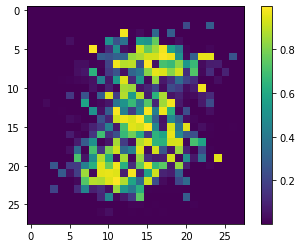

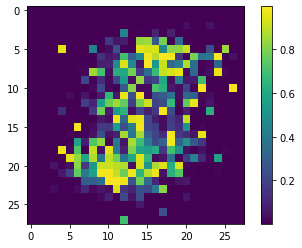

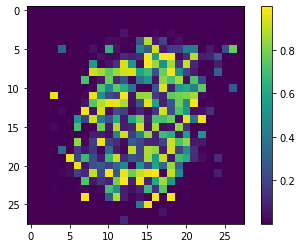

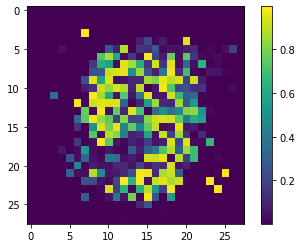

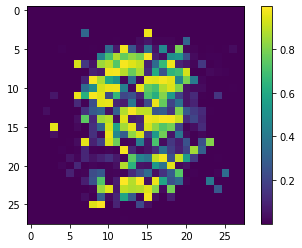

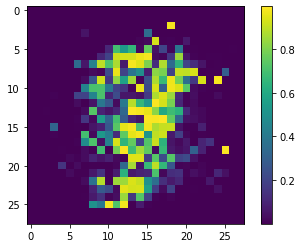

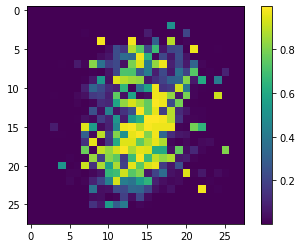

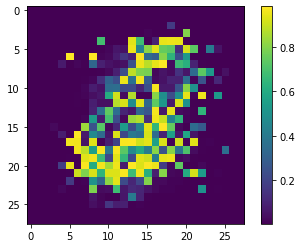

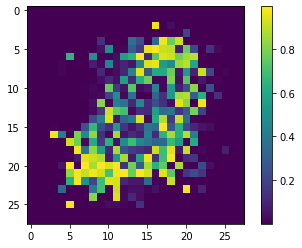

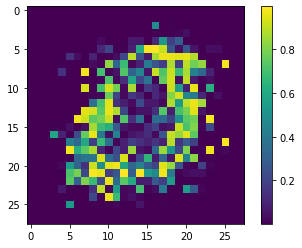

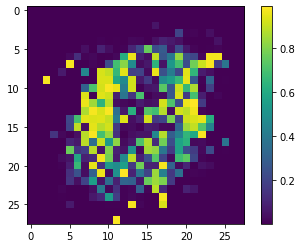

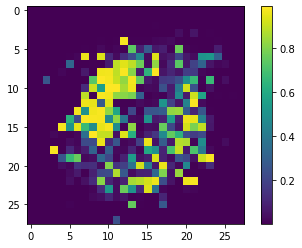

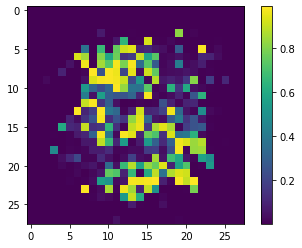

In [17]:
for i in range(20):
  print("\n\n\tTraining for ", (i+1), "th time\n\n")
  
  train_discriminator(g_model, d_model)

  print("--------------")

  train_generator(g_model, d_model)

  noise= generate_noise(noise_dim)
  image= g_model.predict(noise)
  draw_image(image[0])



	Training for  1 th time


60/60 [==============================] - 3s 53ms/step - loss: 0.0874 - accuracy: 0.9787
--------------
Epoch 1/3
60/60 [==============================] - 5s 76ms/step - loss: 2.5950 - accuracy: 0.4389
Epoch 2/3
60/60 [==============================] - 5s 77ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 77ms/step - loss: 0.0026 - accuracy: 1.0000


	Training for  2 th time


60/60 [==============================] - 3s 53ms/step - loss: 0.0862 - accuracy: 0.9789
--------------
Epoch 1/3
60/60 [==============================] - 5s 75ms/step - loss: 2.3770 - accuracy: 0.4389
Epoch 2/3
60/60 [==============================] - 5s 76ms/step - loss: 0.0144 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 75ms/step - loss: 0.0031 - accuracy: 1.0000


	Training for  3 th time


60/60 [==============================] - 3s 54ms/step - loss: 0.0897 - accuracy: 0.9772
--------------
Epoch 1/3
60/60 

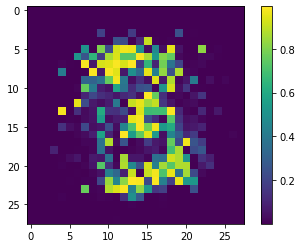

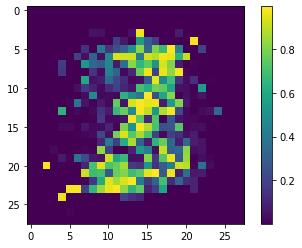

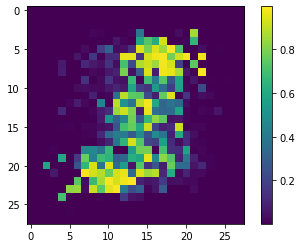

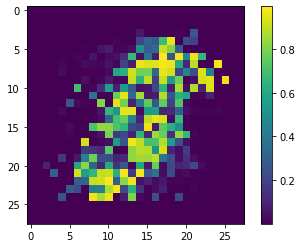

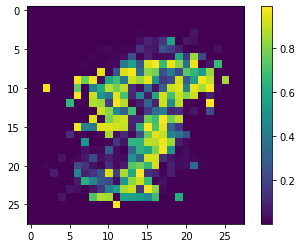

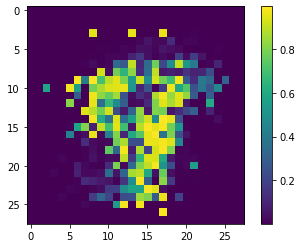

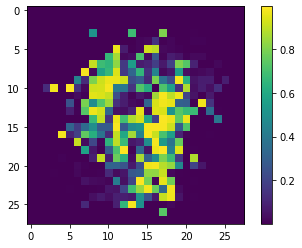

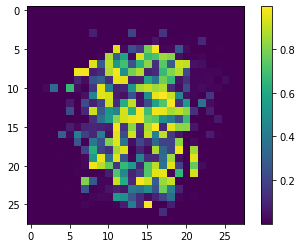

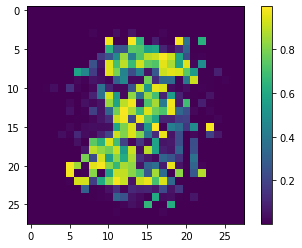

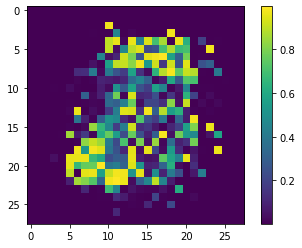

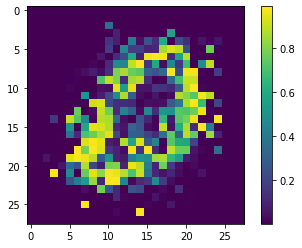

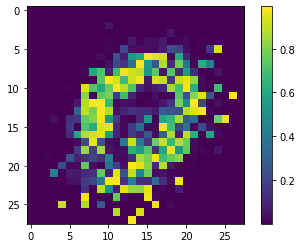

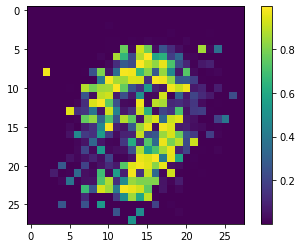

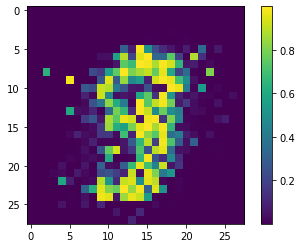

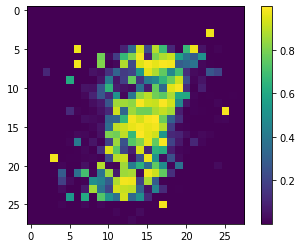

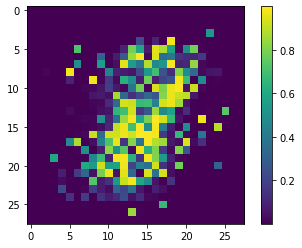

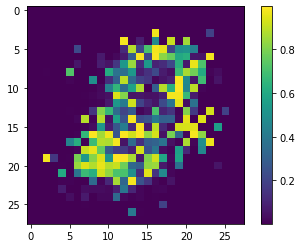

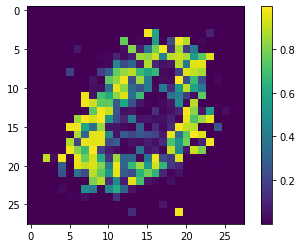

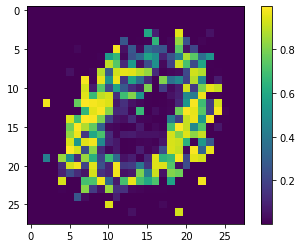

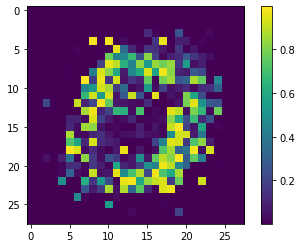

In [18]:
for i in range(20):
  print("\n\n\tTraining for ", (i+1), "th time\n\n")
  
  train_discriminator(g_model, d_model)

  print("--------------")

  train_generator(g_model, d_model)

  noise= generate_noise(noise_dim)
  image= g_model.predict(noise)
  draw_image(image[0])



	Training for  1 th time


60/60 [==============================] - 3s 52ms/step - loss: 0.0763 - accuracy: 0.9859
--------------
Epoch 1/3
60/60 [==============================] - 5s 77ms/step - loss: 2.2613 - accuracy: 0.4898
Epoch 2/3
60/60 [==============================] - 5s 76ms/step - loss: 0.0129 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 77ms/step - loss: 0.0035 - accuracy: 1.0000


	Training for  2 th time


60/60 [==============================] - 3s 52ms/step - loss: 0.0773 - accuracy: 0.9792
--------------
Epoch 1/3
60/60 [==============================] - 6s 79ms/step - loss: 2.2679 - accuracy: 0.4898
Epoch 2/3
60/60 [==============================] - 5s 76ms/step - loss: 0.0151 - accuracy: 1.0000
Epoch 3/3
60/60 [==============================] - 5s 75ms/step - loss: 0.0048 - accuracy: 1.0000


	Training for  3 th time


60/60 [==============================] - 3s 55ms/step - loss: 0.0815 - accuracy: 0.9782
--------------
Epoch 1/3
60/60 

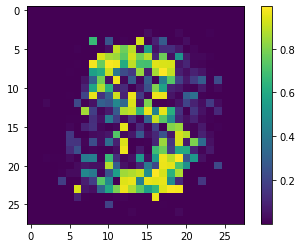

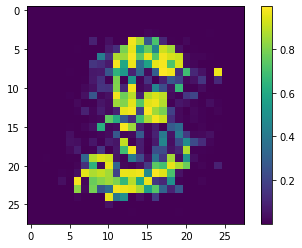

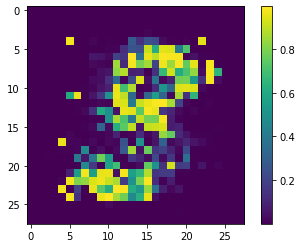

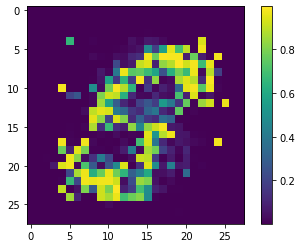

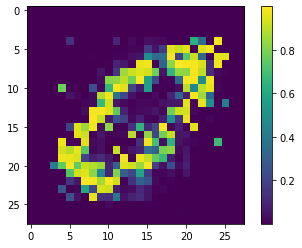

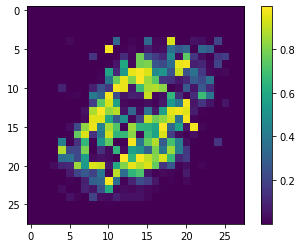

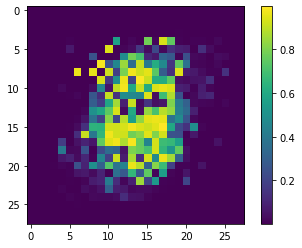

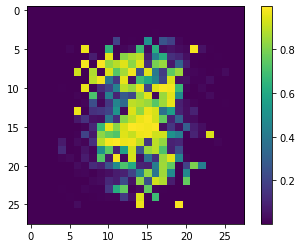

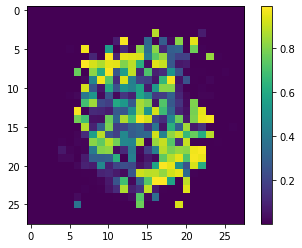

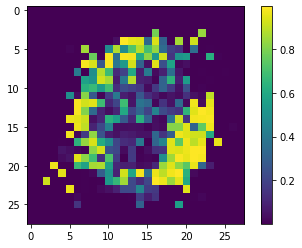

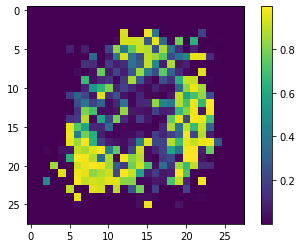

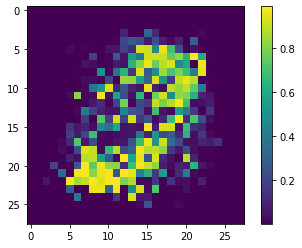

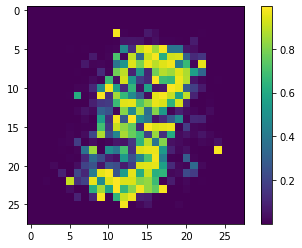

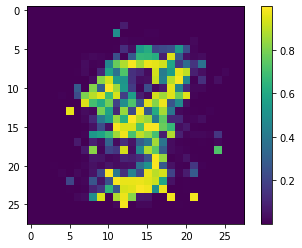

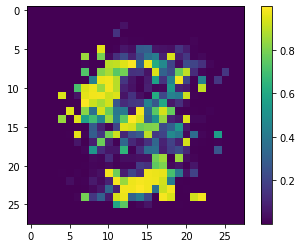

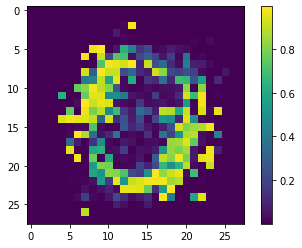

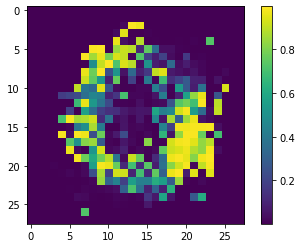

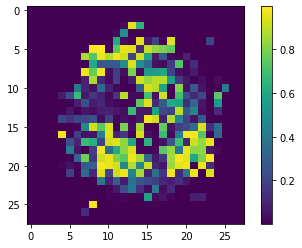

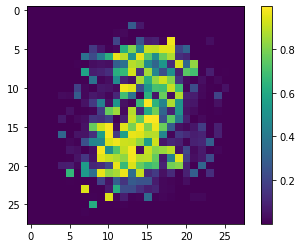

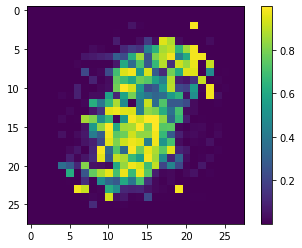

In [19]:
for i in range(20):
  print("\n\n\tTraining for ", (i+1), "th time\n\n")
  
  train_discriminator(g_model, d_model)

  print("--------------")

  train_generator(g_model, d_model)

  noise= generate_noise(noise_dim)
  image= g_model.predict(noise)
  draw_image(image[0])